In [55]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
import pandas as pd
from nltk.tokenize import word_tokenize
import re
import string
import numpy as np
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from scipy import interp
import pickle
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pos_list=[]
neg_list=[]
with open("positive.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        pos_list.append(words[i].string.strip('\n'))
    #print(list)
with open("negative.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        neg_list.append(words[i].string.strip('\n'))

In [3]:
amazondata=pd.read_csv("Amazon Electronics.csv")

In [4]:
amazonlist=[]
for val in amazondata['reviews']:
    amazonlist.append(val)


In [5]:
df = pd.DataFrame()
stop_words = stopwords.words('english')
porter=PorterStemmer()

def clean_data(data):
    new=[]
    newlist=[]
    for i in data:    
        i = re.sub(r"\'m", " am", i)
        i = re.sub(r"\'ve", " have", i)
        i = re.sub(r"n\'t", " not", i)
        i = re.sub(r"\'re", " are", i)
        i = re.sub(r"\'s", " is", i)
        i = re.sub(r"\'d", " would", i)
        i = re.sub(r"\'ll", " will", i)
        i = re.sub(r"(\n+)", " ", i)
        i=i.lower()
        table = str.maketrans(dict.fromkeys(string.punctuation))
        new.append(i.translate(table))
    for text in new:
        sentence=[]
        word_list=text.split(' ')
        for word in word_list:
            if word not in stop_words and word.isalpha() and len(word)>2:            
                sentence.append(porter.stem(word))
        newlist.append(' '.join(sentence))
    return newlist

cleanpos_list=clean_data(pos_list)
cleanneg_list=clean_data(neg_list)
cleanamazon_list=clean_data(amazonlist)



In [6]:
df_amazon = pd.DataFrame(cleanamazon_list)
df_amazon['sentiment']=amazondata['sentiment']
df_amazon.columns = ['reviews', 'sentiment']  
df_amazon.shape

(4000, 2)

In [7]:
df_pos = pd.DataFrame(cleanpos_list)
df_pos['sentiment'] = np.ones(len(cleanpos_list))
df_pos.columns = ['reviews', 'sentiment']

df_neg = pd.DataFrame(cleanneg_list)
df_neg['sentiment'] = np.zeros(len(cleanneg_list))
df_neg.columns = ['reviews', 'sentiment']

df = df_pos.append(df_neg,ignore_index=True)
finaldf=df.append(df_amazon,ignore_index=True)
print(finaldf.tail())
print(finaldf.shape)

                                                reviews  sentiment
5993                  warn wear big chanc hear one near        1.0
5994  nice lightweight pluse tradit durabl lightweig...        1.0
5995     seem work fine rememb take tini rubber cap end        1.0
5996  hand easiest best made full motion mount bough...        1.0
5997                          great price great qualiti        1.0
(5998, 2)


In [9]:

finallist=[]
count=0
for text in finaldf.values:
    newlist=[]
    word_list=text[0].split(' ')
    for word in word_list:       
        newlist.append(word)
    finallist.append(newlist)

In [10]:
finaldf = shuffle(finaldf)

In [11]:
from sklearn.model_selection import train_test_split
X = finaldf['reviews']
y = finaldf['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4798,), (4798,), (1200,), (1200,))

In [12]:
X_train1=X_train.copy()
X_train1.shape

(4798,)

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Using TensorFlow backend.


In [14]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

vocab_size = len(tokenizer.word_index) + 1

max_length = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
vocab_size

9358

In [15]:
from gensim.models import Word2Vec
wordlist=[]

model = Word2Vec(finallist,min_count=5,
                 window=2,
                 size=300,
                 sample=6e-5, 
                 alpha=0.03, 
                 min_alpha=0.0007, 
                 negative=2,
                 workers=8
        )
words=list(model.wv.vocab)
print("Total vocabulary size:",len(words))
#print(words)

Total vocabulary size: 2880


In [17]:
filename="word2vec_embeddings.txt"
model.wv.save_word2vec_format(filename, binary=False)

In [18]:
import os
embeddings_index={}
f=open(os.path.join('','word2vec_embeddings.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

In [19]:
#num_words=len(word_index)+1
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if i>vocab_size:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
print(vocab_size)

9358


In [20]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Masking, Activation, Input
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model

LSTM_model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True,mask_zero=True)

LSTM_model.add(embedding_layer)

LSTM_model.add(LSTM(128))

LSTM_model.add(Dense(1, activation='sigmoid'))

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
print(LSTM_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         2807400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,027,177
Trainable params: 3,027,177
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
history = LSTM_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = LSTM_model.evaluate(X_test, y_test, verbose=1)

C:\Users\Jithu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3838 samples, validate on 960 samples
Epoch 1/5
3838/3838 [==============================] - 17s 4ms/step - loss: 0.5718 - accuracy: 0.7288 - val_loss: 0.4352 - val_accuracy: 0.8333
Epoch 2/5
3838/3838 [==============================] - 16s 4ms/step - loss: 0.2644 - accuracy: 0.9075 - val_loss: 0.3791 - val_accuracy: 0.8656
Epoch 3/5
3838/3838 [==============================] - 14s 4ms/step - loss: 0.1383 - accuracy: 0.9536 - val_loss: 0.4011 - val_accuracy: 0.8594
Epoch 4/5
3838/3838 [==============================] - 16s 4ms/step - loss: 0.0880 - accuracy: 0.9729 - val_loss: 0.5398 - val_accuracy: 0.8500
Epoch 5/5
1200/1200 [==============================] - 2s 2ms/step


In [27]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

def evaluate_model(X_test, y_test, model):
    # predict probabilities for test set
    _probs = model.predict(X_test, verbose=0)
    # predict crisp classes for test set
    _classes = model.predict_classes(X_test, verbose=0)
    # reduce to 1d array
    _probs = _probs[:, 0]
    _classes = _classes[:, 0]

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, _classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, _classes)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, _classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, _classes)
    
    fpr, tpr, _ = roc_curve(y_test, _probs)
    
    tpr_transformed = np.array([interp(mean_fpr, fpr, tpr)])
    
    # compute the area under the curve
    _auc = auc(fpr, tpr)
    
    return accuracy, precision, recall, f1, tpr_transformed,_auc

In [28]:
LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1_score, LSTM_tpr,LSTM_auc = evaluate_model(X_test, y_test, LSTM_model)
print("LSTM_accuracy: {:.5f}".format(LSTM_accuracy))
print("LSTM_precision: {:.5f}".format(LSTM_precision))
print("LSTM_recall: {:.5f}".format(LSTM_recall))
print("LSTM_f1_score: {:.5f}".format(LSTM_f1_score))

LSTM_accuracy: 0.84333
LSTM_precision: 0.85764
LSTM_recall: 0.82333
LSTM_f1_score: 0.84014


C:\Users\Jithu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


# Pseudo Label 

In [19]:
pseudolabel=pd.read_csv("Unlabelled.csv")

In [20]:
pseusolabellist=[]
for val in pseudolabel['reviews']:
    pseusolabellist.append(val)

In [21]:
cleanpseudolabel=clean_data(pseusolabellist)


In [22]:
df_pseudo = pd.DataFrame(cleanpseudolabel)
df_pseudo.columns = ['reviews']

In [23]:
df_pseudo.head()

,reviews
0,purchas unit due frequent blackout area power ...
1,first want power up good reason never want mac...
2,bought backup imac got wife christma apc sinc ...
3,unfortun earlier review indic unit seriou flaw...
4,order apc backup recommend employe mine use wo...


In [24]:
pseudo_train=df_pseudo['reviews']
pseudo_train = tokenizer.texts_to_sequences(pseudo_train)

In [35]:
pseudo_train = pad_sequences(pseudo_train, padding='post', maxlen=max_length)

In [37]:
pseudo_predict=LSTM_model.predict_classes(pseudo_train)

In [38]:
pseudo_label = pd.DataFrame(pseudo_predict)
pseudo_label.columns=['sentiment']

In [39]:
final_pseudo=df_pseudo['reviews']
final_pseudolabel=pseudo_label['sentiment']

In [40]:
X.shape

(5998,)

In [41]:
X_pseudo = np.concatenate((X, final_pseudo), axis=0)
Y_pseudo = np.concatenate((y, final_pseudolabel), axis=0)

X_pseudo.shape

(7998,)

In [42]:
finallist_pseudo=[]
for text in X_pseudo:
    newlist_pseudo=[]
    word_list_pseudo=text.split(' ')
    for word in word_list_pseudo:       
        newlist_pseudo.append(word)
    finallist_pseudo.append(newlist_pseudo)

In [43]:
X_pseudo_train, X_pseudo_test, y_pseudo_train, y_pseudo_test = train_test_split(X_pseudo, Y_pseudo, test_size=0.2,stratify=Y_pseudo,shuffle=True,random_state = 1)
X_pseudo_train.shape, y_pseudo_train.shape, X_pseudo_test.shape, y_pseudo_test.shape

((6398,), (6398,), (1600,), (1600,))

In [44]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_pseudo_train)

X_pseudo_train = tokenizer.texts_to_sequences(X_pseudo_train)
X_pseudo_test = tokenizer.texts_to_sequences(X_pseudo_test)

In [45]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

vocab_size = len(tokenizer.word_index) + 1

max_length = 100

X_pseudo_train = pad_sequences(X_pseudo_train, padding='post', maxlen=max_length)
X_pseudo_test = pad_sequences(X_pseudo_test, padding='post', maxlen=max_length)
vocab_size

11240

In [46]:
from gensim.models import Word2Vec

pseudo_model = Word2Vec(finallist_pseudo,min_count=5,
                 window=2,
                 size=300,
                 sample=6e-5, 
                 alpha=0.03, 
                 min_alpha=0.0007, 
                 negative=2,
                 workers=8
        )
words=list(pseudo_model.wv.vocab)
print("Total vocabulary size:",len(words))

Total vocabulary size: 3571


In [47]:
filename="pseudolabel_word2vec_embeddings.txt"
pseudo_model.wv.save_word2vec_format(filename, binary=False)

In [48]:
import os
embeddings_index={}
f=open(os.path.join('','pseudolabel_word2vec_embeddings.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

In [49]:
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if i>vocab_size:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
print(vocab_size)

11240


In [50]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Masking, Activation, Input
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model

Pseudolabel_lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True,mask_zero=True)

Pseudolabel_lstm_model.add(embedding_layer)

Pseudolabel_lstm_model.add(LSTM(128))

Pseudolabel_lstm_model.add(Dense(1, activation='sigmoid'))

Pseudolabel_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
Pseudolabel_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3372000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,591,777
Trainable params: 3,591,777
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = Pseudolabel_lstm_model.fit(X_pseudo_train, y_pseudo_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = Pseudolabel_lstm_model.evaluate(X_pseudo_test, y_pseudo_test, verbose=1)

C:\Users\Jithu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5118 samples, validate on 1280 samples
Epoch 1/5
5118/5118 [==============================] - 22s 4ms/step - loss: 0.5419 - accuracy: 0.7169 - val_loss: 0.3399 - val_accuracy: 0.8555
Epoch 2/5
5118/5118 [==============================] - 20s 4ms/step - loss: 0.2260 - accuracy: 0.9174 - val_loss: 0.3195 - val_accuracy: 0.8633
Epoch 3/5
5118/5118 [==============================] - 20s 4ms/step - loss: 0.1118 - accuracy: 0.9611 - val_loss: 0.3860 - val_accuracy: 0.8586
Epoch 4/5
5118/5118 [==============================] - 20s 4ms/step - loss: 0.0768 - accuracy: 0.9764 - val_loss: 0.4000 - val_accuracy: 0.8562
Epoch 5/5
1600/1600 [==============================] - 3s 2ms/step


In [53]:
Pseudolabel_LSTM_accuracy, Pseudolabel_LSTM_precision, Pseudolabel_LSTM_recall, Pseudolabel_LSTM_f1_score, Pseudolabel_LSTM_tpr,Pseudolabel_LSTM_auc = evaluate_model(X_pseudo_test, y_pseudo_test, Pseudolabel_lstm_model)
print("Pseudolabel_LSTM_accuracy: {:.5f}".format(Pseudolabel_LSTM_accuracy))
print("Pseudolabel_LSTM_precision: {:.5f}".format(Pseudolabel_LSTM_precision))
print("Pseudolabel_LSTM_recall: {:.5f}".format(Pseudolabel_LSTM_recall))
print("Pseudolabel_LSTM_f1_score: {:.5f}".format(Pseudolabel_LSTM_f1_score))

Pseudolabel_LSTM_accuracy: 0.85437
Pseudolabel_LSTM_precision: 0.86777
Pseudolabel_LSTM_recall: 0.85864
Pseudolabel_LSTM_f1_score: 0.86318


C:\Users\Jithu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


# Bar Plot

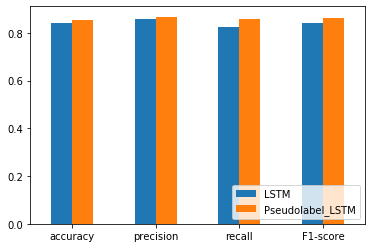

In [56]:
LSTM_metrics = np.array([LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1_score])
Pseudolabel_LSTM_metrics = np.array([Pseudolabel_LSTM_accuracy, Pseudolabel_LSTM_precision, Pseudolabel_LSTM_recall, Pseudolabel_LSTM_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'LSTM': LSTM_metrics,'Pseudolabel_LSTM': Pseudolabel_LSTM_metrics }, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

# ROC Curve

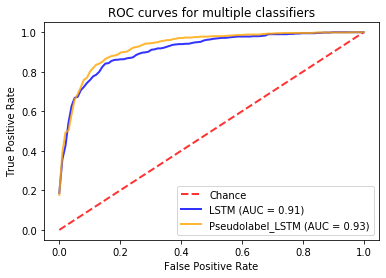

In [57]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, LSTM_tpr[0,:], lw=2, color='blue', label='LSTM (AUC = %0.2f)' % (LSTM_auc), alpha=0.8)
plt.plot(mean_fpr, Pseudolabel_LSTM_tpr[0,:], lw=2, color='orange', label='Pseudolabel_LSTM (AUC = %0.2f)' % (Pseudolabel_LSTM_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()